In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from time_series_influences.utils import split_time_series, match_train_time_block_index
from time_series_influences.influence_functions import compute_loo_linear_approx
from time_series_influences.anomaly_detection import scale_influence_functions, eval_anomaly_detector

seed = 666
np.random.seed(seed)

In [101]:
dataset = "SMD"
data_path = Path("../data/multivariate/") / dataset

In [108]:
ts = np.load(data_path/f"{dataset}_train.npy")
ts_test = np.load(data_path/f"{dataset}_test.npy")
test_labels = np.load(data_path/f"{dataset}_test_label.npy")
anomaly_idx = np.where(test_labels == 1)[0] + len(ts)

In [109]:
ts_test = ts_test[10000:12000]
test_labels = test_labels[10000:12000]

/var/folders/qj/1nl7l6r17s51bt62dx3x0rt40000gn/T/ipykernel_7007/1111853276.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(16,1))


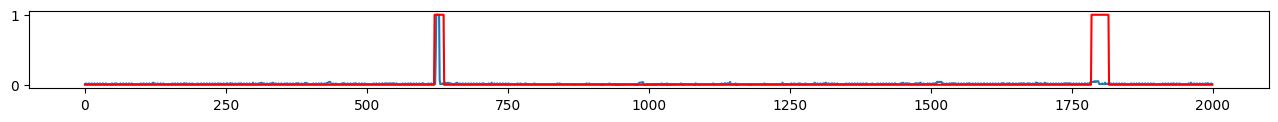

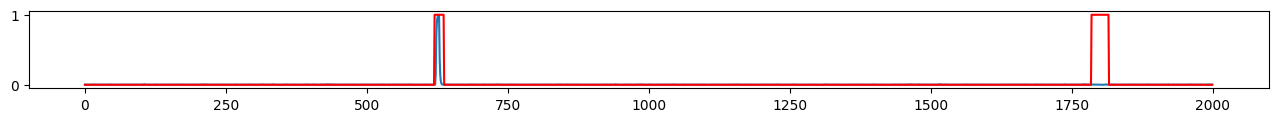

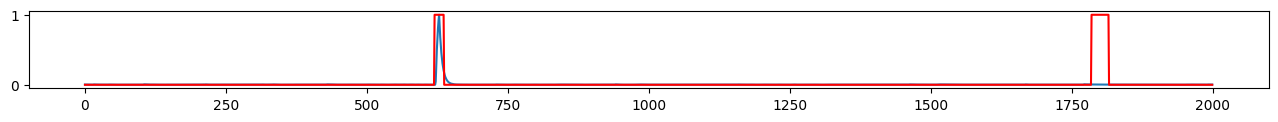

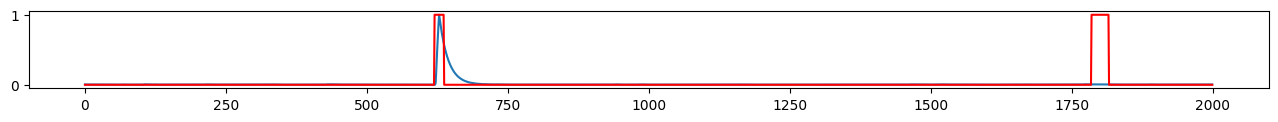

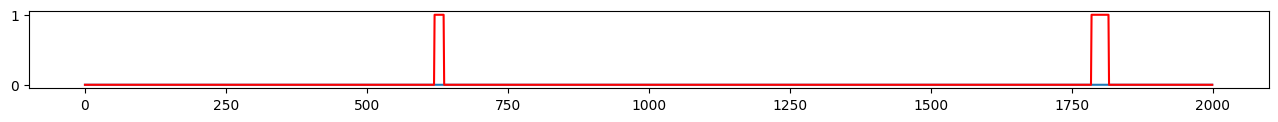

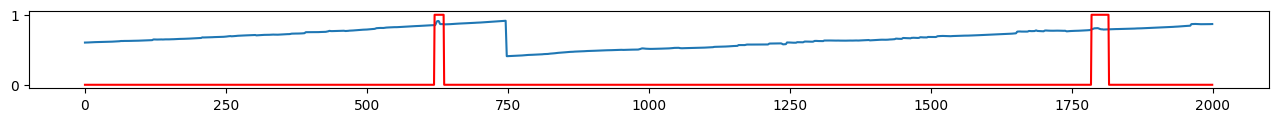

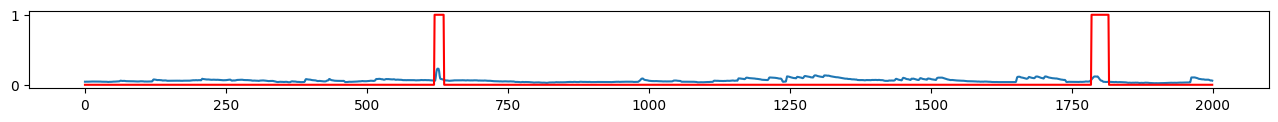

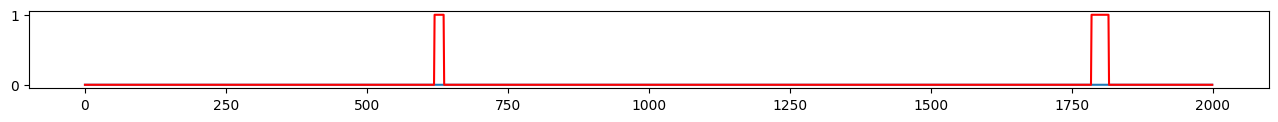

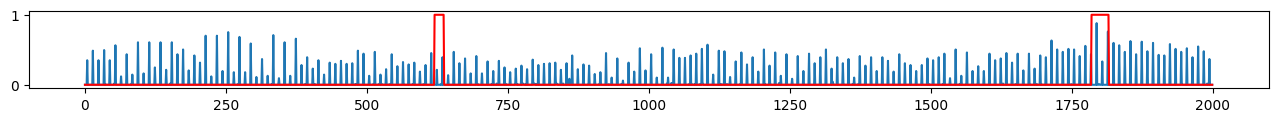

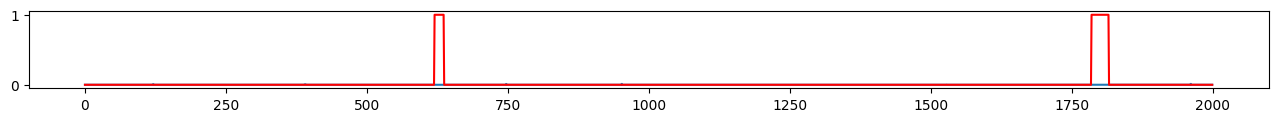

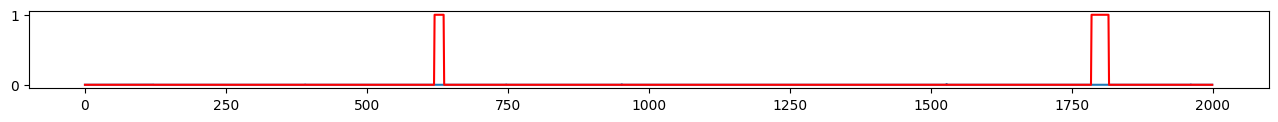

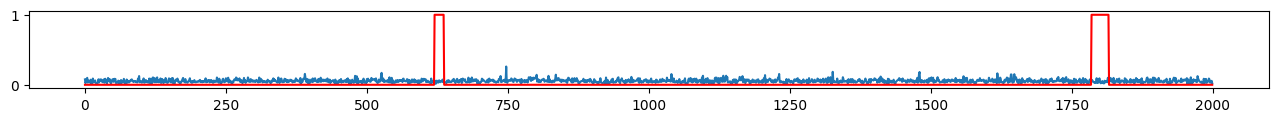

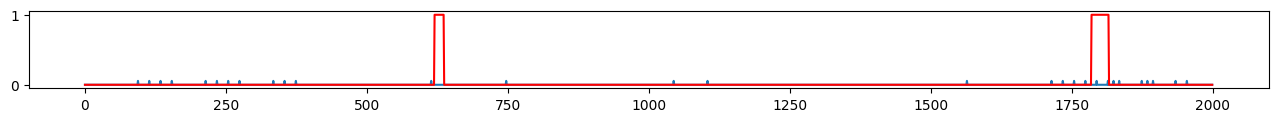

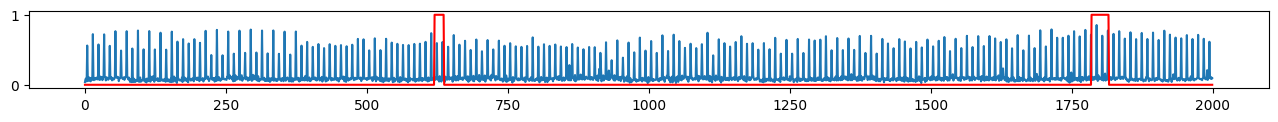

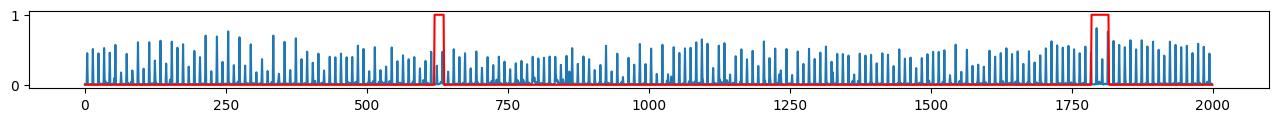

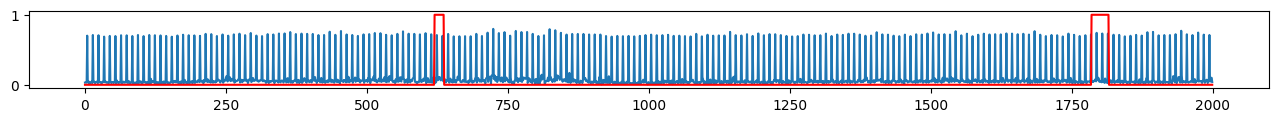

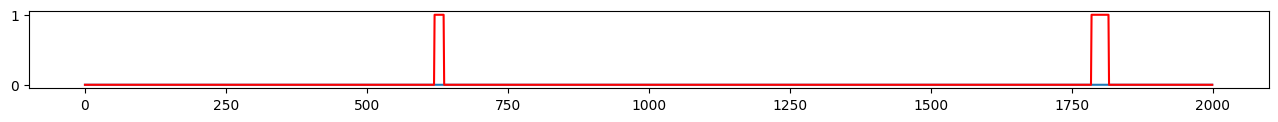

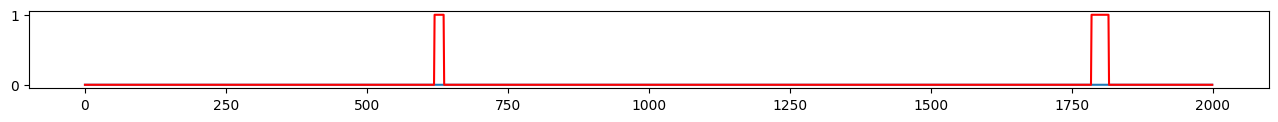

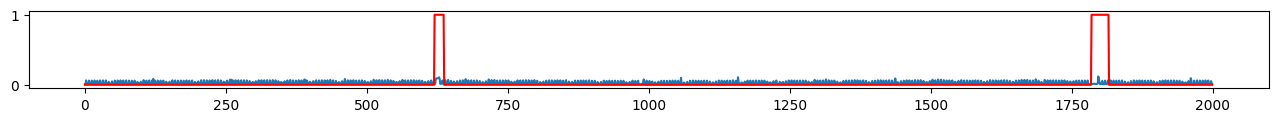

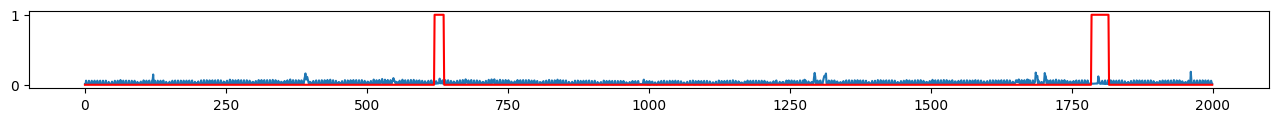

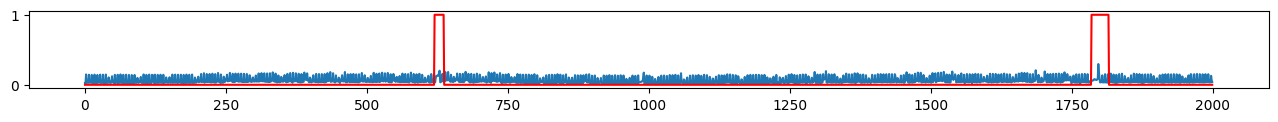

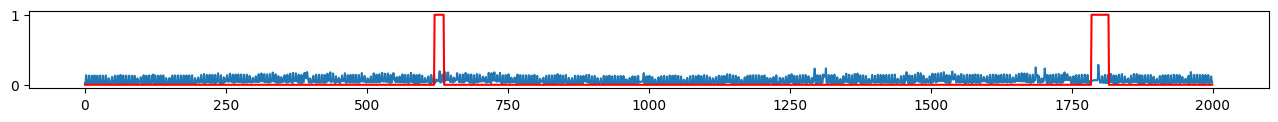

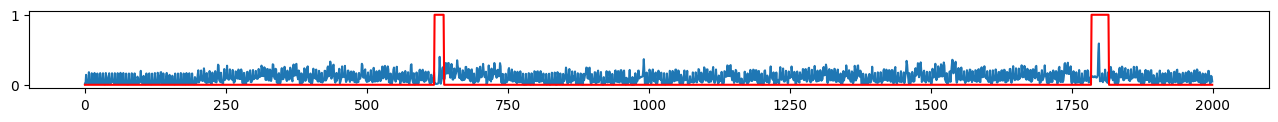

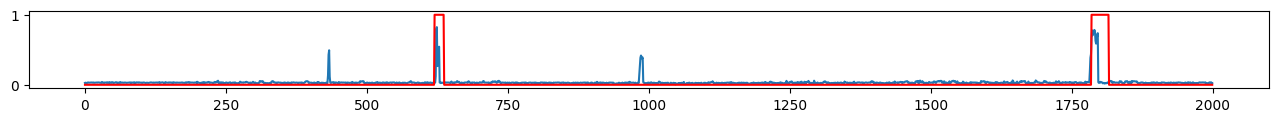

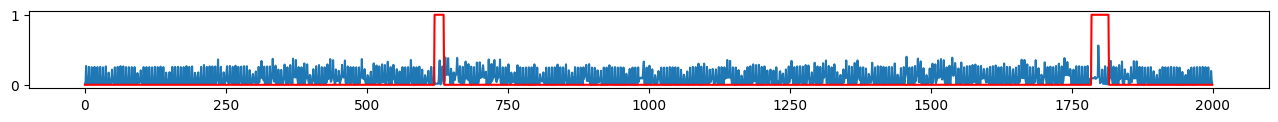

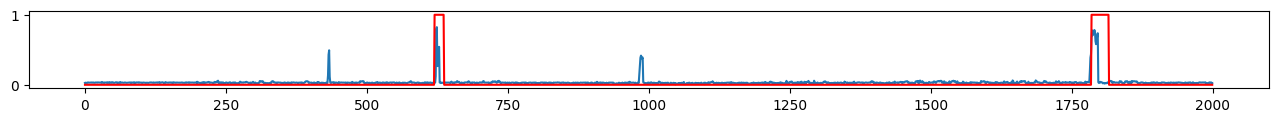

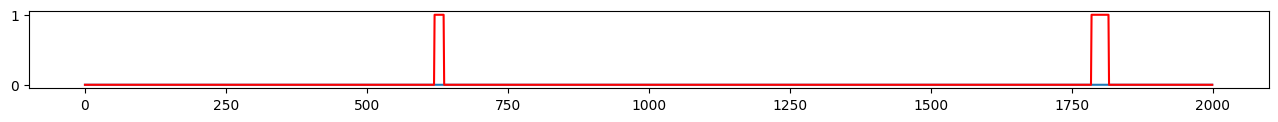

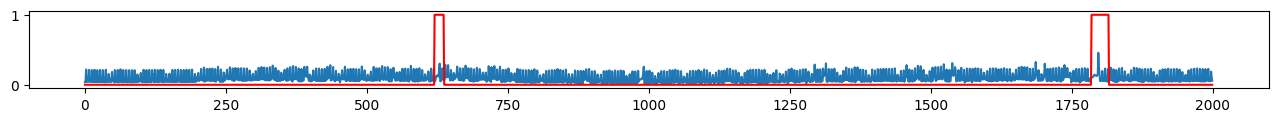

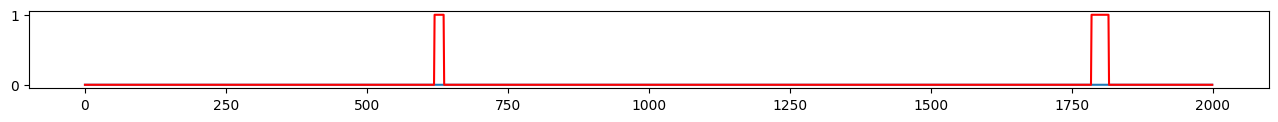

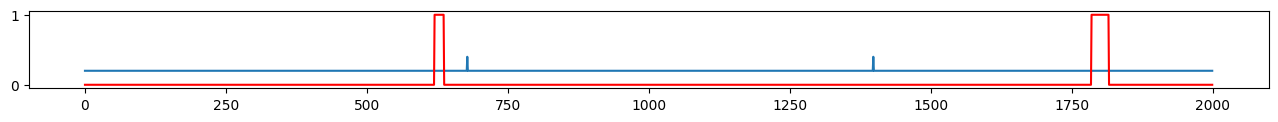

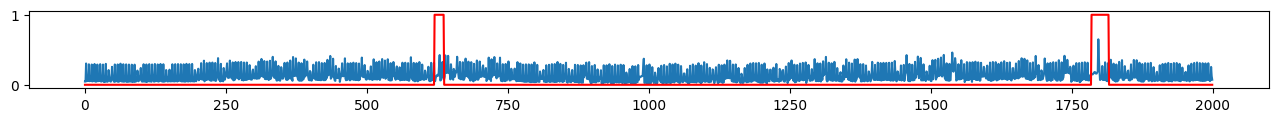

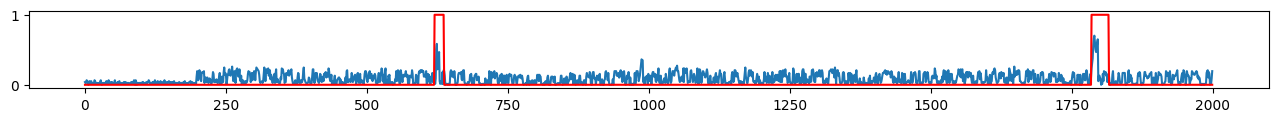

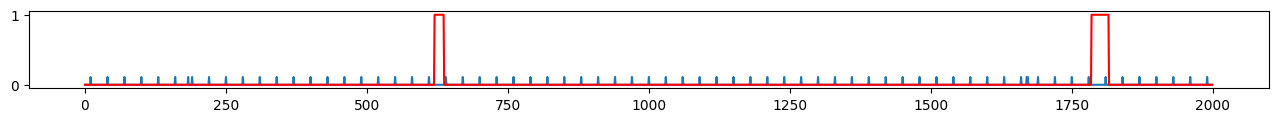

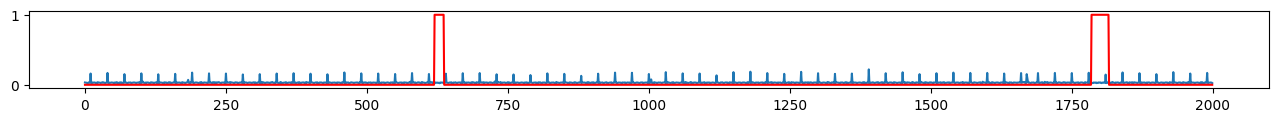

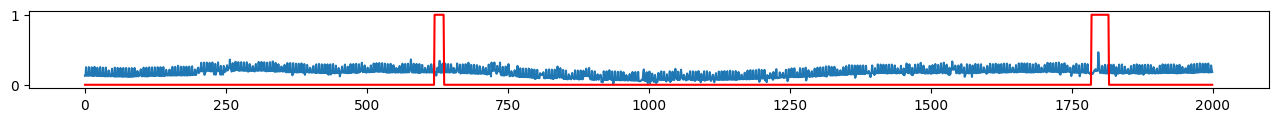

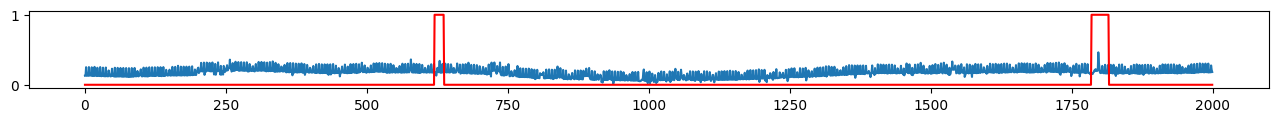

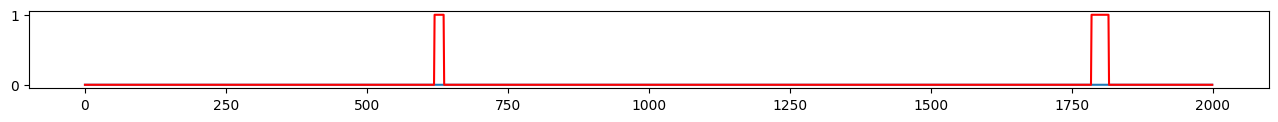

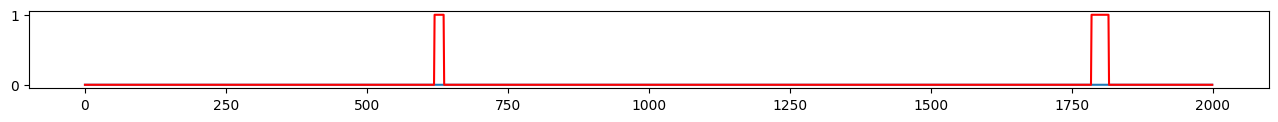

In [110]:
for ts_idx in range(len(ts_test.T)):
    plt.figure(figsize=(16,1))
    plt.plot(ts_test.T[ts_idx])
    plt.plot(test_labels, c='red');

In [111]:
block_length = 10
X_train, Y_train = split_time_series(ts_test, block_length=block_length)
matched_block_idxs = match_train_time_block_index(ts_test, X_train)
print(X_train.shape, Y_train.shape)

(1990, 10, 38) (1990, 38)


In [112]:
seq_len, _, n_series = X_train.shape
X_train = X_train.reshape(seq_len, block_length*n_series)

In [113]:
lr = LinearRegression().fit(X_train, Y_train)
beta = lr.coef_
b = lr.intercept_
try:
    inv_hess = len(X_train) * np.linalg.inv(X_train.T @ X_train)
except:
    inv_hess = len(X_train) * np.linalg.pinv(X_train.T @ X_train)
params = (beta, b, inv_hess)

In [114]:
# compute IF for each time block
time_block_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  time_block_loos.append(compute_loo_linear_approx(i, i, X_train, Y_train, X_train, Y_train, params))
time_block_loos = np.array(time_block_loos)

Compute LOO: 100%|████████████████████████| 1990/1990 [00:00<00:00, 9103.21it/s]


In [115]:
# compute IF for each time point
time_point_loos = []
for i in range(len(matched_block_idxs)):
  time_point_loos.append((time_block_loos[matched_block_idxs[i]]).mean())
time_point_loos = np.array(time_point_loos)

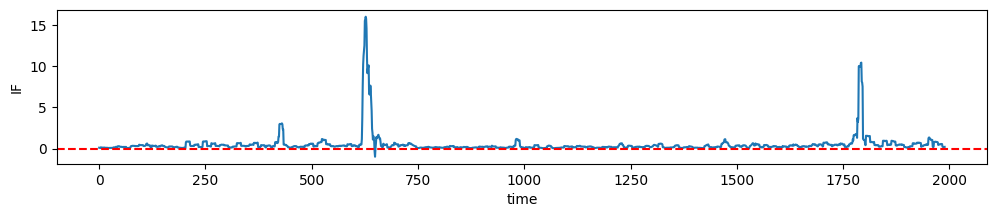

In [116]:
plt.figure(figsize=(12,2))
loos_viz = np.ones(len(ts_test)) * np.nan
loos_viz[:X_train.shape[0]] = time_point_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.ylabel("IF")
plt.xlabel("time")
plt.show()

In [117]:
anomaly_scores = scale_influence_functions(time_point_loos, block_length=block_length)

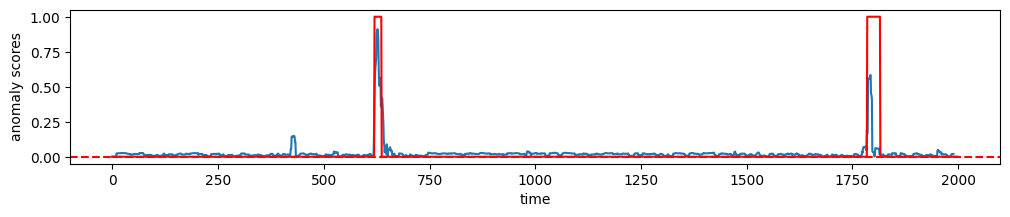

In [118]:
plt.figure(figsize=(12,2))
loos_viz = np.ones(len(ts_test)) * np.nan
loos_viz[:X_train.shape[0]] = anomaly_scores
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.plot(test_labels, c='red')
plt.ylabel("anomaly scores")
plt.xlabel("time")
plt.show()

In [119]:
contam_ratio = block_length / len(ts_test)
detected_outliers = np.zeros(len(ts_test))
detected_outliers = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)

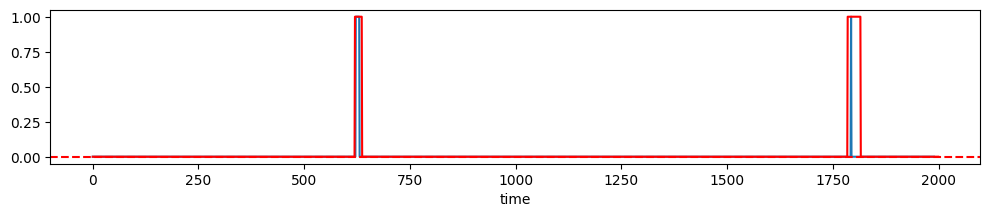

In [120]:
plt.figure(figsize=(12,2))
loos_viz = np.ones(len(ts_test)) * np.nan
loos_viz[:X_train.shape[0]] = detected_outliers
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.plot(test_labels, c='red')
plt.xlabel("time")
plt.show()

In [121]:
prec, rec, f1 = eval_anomaly_detector(test_labels[:len(detected_outliers)], detected_outliers, adjust_detection=True)

precision: 1.000 recall: 1.000 F1: 1.000
